In [549]:
#import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

<h3>Read and Explore the Data</h3>

In [594]:
df = pd.read_csv('data.csv', error_bad_lines=False, warn_bad_lines=False, sep=r'\t')

<ipython-input-594-5aabe5359ee8>:1: ParserWarning:

Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.



In [595]:
#explore the shape of data
df.head()

,Q1A,Q1I,Q1E,Q2A,Q2I,Q2E,Q3A,Q3I,Q3E,Q4A,...,screensize,uniquenetworklocation,hand,religion,orientation,race,voted,married,familysize,major
0,4,28,3890,4,25,2122,2,16,1944,4,...,1,1,1,12,1,10,2,1,2,None
1,4,2,8118,1,36,2890,2,35,4777,3,...,2,1,2,7,0,70,2,1,4,None
2,3,7,5784,1,33,4373,4,41,3242,1,...,2,1,1,4,3,60,1,1,3,None
3,2,23,5081,3,11,6837,2,37,5521,1,...,2,1,2,4,5,70,2,1,5,biology
4,2,36,3215,2,13,7731,3,5,4156,4,...,2,2,3,10,1,10,2,1,4,Psychology


In [596]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39775 entries, 0 to 39774
Columns: 172 entries, Q1A to major
dtypes: int64(170), object(2)
memory usage: 52.2+ MB


In [597]:
#check the shape of dataset
df.shape

(39775, 172)

The dataset contains 172 columns most of them are test questions scores, so we will do the following before starting cleaning:<br>
<ul>
<li>Calculate score of Stress,Anxiety and depression from Question Related, based on <a href='https://www.psytoolkit.org/survey-library/depression-anxiety-stress-dass.html'>DASS</a></li>
<li>Calculate the Five Personlity score from TIPI Question Rekated in dataset, based on  <a href="http://gosling.psy.utexas.edu/wp-content/uploads/2014/09/JRP-03-tipi.pdf" rel=" noreferrer nofollow">http://gosling.psy.utexas.edu/wp-content/uploads/2014/09/JRP-03-tipi.pdf</a><l/i>
    <li>add Category of Stress,Anxiety and depression to dataset</li>    
<li> Remove the Test Columns and other non-related features to study</li>
</ul> 
 <a href='https://www.kaggle.com/solvalou/dass-eda#Personality-results'> Code used for calculations  </a>

In [598]:
#find null in all dataset in case it has affect on final score of calculation process
null_counts = df.isnull().sum()
null_counts[null_counts > 0].sort_values(ascending=False)

major      11407
country        2
dtype: int64

In [599]:
#major and country don't affect the calculation
#1- D,A,S questions based sum result
DASS_keys = { 'Stress': [1, 6, 8, 11, 12, 14, 18, 22, 27, 29, 32, 33, 35, 39],
              'Anxiety': [2, 4, 7, 9, 15, 19, 20, 23, 25, 28, 30, 36, 40, 41],
             'Depression': [3, 5, 10, 13, 16, 17, 21, 24, 26, 31, 34, 37, 38, 42]
            
            }
             
for name, keys in DASS_keys.items():
            #find the sum of Depression, anixity and stress
        df[name]=(df.filter(regex='Q(%s)A' % '|'.join(map(str, keys))) - 1).sum(axis=1)
       

In [600]:
#2- Calculate the Five Personlity score 
# Add personality types to data
personality_types = ['Extraversion', 'Agreeableness', 'Conscientiousness', 'EmotionalStability', 'Openness']

# Invert some entries
tipi = df.filter(regex='TIPI\d+').copy()
tipi_inv = tipi.filter(regex='TIPI(2|4|6|8|10)').apply(lambda d: 7 - d)
tipi[tipi.columns.intersection(tipi_inv.columns)] = tipi_inv

# Calculate scores
for idx, pt in enumerate( personality_types ):
    df[pt] = tipi[['TIPI{}'.format(idx + 1), 'TIPI{}'.format(6 + idx)]].mean(axis=1)

personalities = df[personality_types]

<h3>Interpretation of DASS scores</h3>
<table class="dataframe"  width="70%" >

<thead>
<tr>
<th style="text-align: left;">Meaning</th>
<th>Depression</th>
<th>Anxiety</th>
<th>Stress</th>
</tr>
</thead>
<tbody>
<tr>
<th style="text-align: left;">Normal</th>
<td>0-9</td>
<td>0-7</td>
<td>0-14</td>
</tr>
<tr>
<th style="text-align: left;"> Mild</th>
<td>10-13</td>
<td>8-9</td>
<td>15-18</td>
</tr>
<tr>
<th style="text-align: left;">Moderate</th>
<td>14-20</td>
<td>10-14</td>
<td>19-25</td>
</tr>
<tr>
<th style="text-align: left;">Severe</th>
<td>21-27</td>
<td>15-19</td>
<td>26-33</td>
</tr>
<tr>
<th style="text-align: left;">Extremely severe</th>
<td>28+</td>
<td>20+</td>
<td>34+</td>
</tr>
</tbody>
</table>

<b> First 3 items in Meaning Column identify Normal</b>
<b>while the 2 others identify high Depression</b><br>
<b>So based on that we will classify the Depression status into Normal=0 and High=1</b>

In [601]:
#we will classify each with high and normal
conditions = [
     (df['Depression'] <= 20),
    (df['Depression'] >=21) 
    ]
conditions2 = [
     (df['Anxiety'] <= 14),
    (df['Anxiety'] >=15) 
    ]

conditions3 = [
  (df['Stress'] <= 25),
    (df['Stress'] >=26) 
    ]
# create a list of the values we want to assign for each condition
values = [0, 1]
df['Anxiety_Lvl'] = np.select(conditions2, values)
df['Stress_Lvl'] = np.select(conditions3, values)
df['Depression_Lvl'] = np.select(conditions, values)

According to research paper "Personality Traits and Urinary Symptoms Are Associated with Mental Health Distress in Patients with a Diagnosis of Prostate Cancer",
Results: Screening positive for mental illness (18.0%) was associated with personality traits of low levels of emotional stability.<br>
also the heatmap shows that fact

In [602]:
#4-drop test columns
df= df[df.columns.drop(list(df.filter(regex='(Q\d+[AIE])|(TIPI\d+)|(VCL\d+)')))]


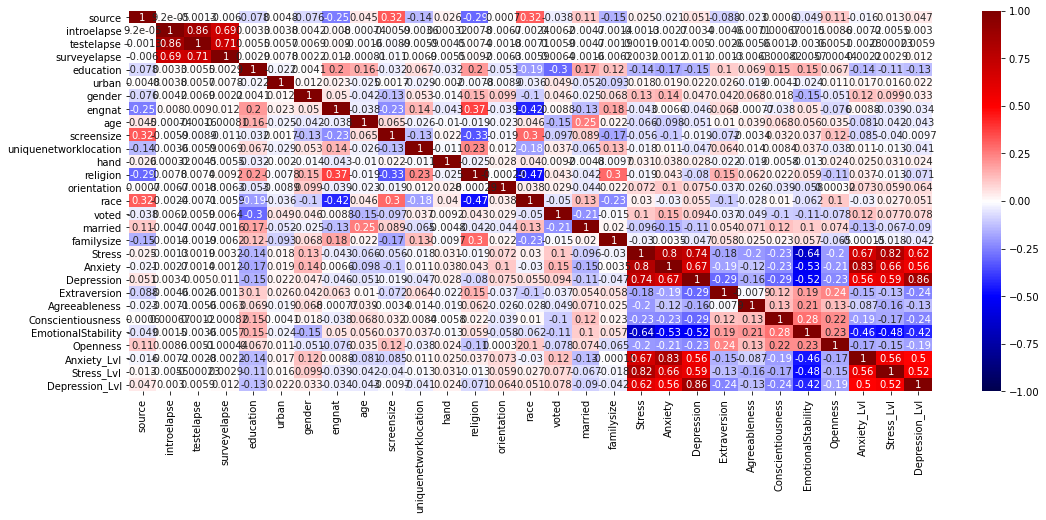

In [603]:
#lets check the correlation map to drop some features
plt.figure(figsize = (18,7))
sns.heatmap(df.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);
plt.show()

In [604]:
#drop columns data which values almost 0 corresponding to dep_lvl  ,
#also the columns where the categories were calculated from 'Stress','Anxiety','Depression'
df_select = df.drop(columns=['source', 'introelapse', 'testelapse', 'surveyelapse','screensize',
                                    'uniquenetworklocation','major','engnat','hand','Stress','Anxiety','Depression','orientation'])

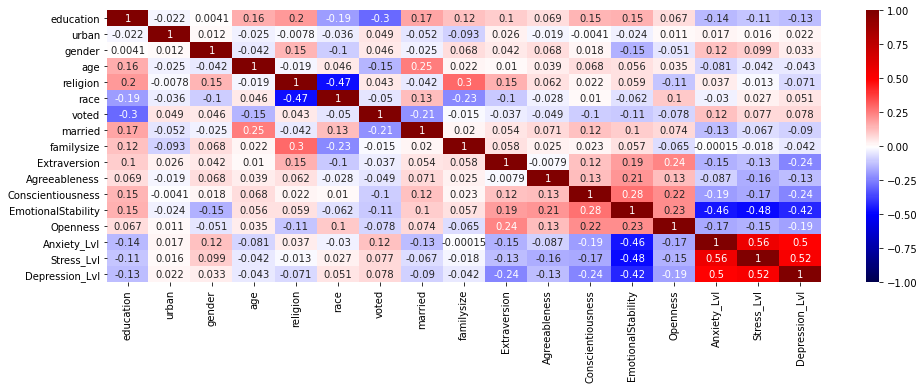

In [605]:
#check heatmap again
plt.figure(figsize = (16,5))
sns.heatmap(df_select.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);
plt.show()

As heat map shows the Depression Level is highly related to anxiety and stress Level and EmotionStability

In [606]:
#######################end of part 1

<h3>Data Cleaning<h3>

In [607]:
#now we will look at the shape of data before starting cleaning
df_select.shape

(39775, 18)

In [608]:
#find the null values
df_select.isnull().sum()

country               2
education             0
urban                 0
gender                0
age                   0
religion              0
race                  0
voted                 0
married               0
familysize            0
Extraversion          0
Agreeableness         0
Conscientiousness     0
EmotionalStability    0
Openness              0
Anxiety_Lvl           0
Stress_Lvl            0
Depression_Lvl        0
dtype: int64

In [609]:
#drop the null vlaues
df_select =df_select.dropna()
df_select.isnull().sum()

country               0
education             0
urban                 0
gender                0
age                   0
religion              0
race                  0
voted                 0
married               0
familysize            0
Extraversion          0
Agreeableness         0
Conscientiousness     0
EmotionalStability    0
Openness              0
Anxiety_Lvl           0
Stress_Lvl            0
Depression_Lvl        0
dtype: int64

In [610]:
df_select

,country,education,urban,gender,age,religion,race,voted,married,familysize,Extraversion,Agreeableness,Conscientiousness,EmotionalStability,Openness,Anxiety_Lvl,Stress_Lvl,Depression_Lvl
0,IN,2,3,2,16,12,10,2,1,2,0.5,4.5,4.5,0.5,6.5,1,1,1
1,US,2,3,2,16,7,70,2,1,4,4.5,4.5,2.0,0.5,3.5,1,1,1
2,PL,2,3,2,17,4,60,1,1,3,1.5,3.5,2.0,4.0,5.0,0,0,1
3,US,1,3,2,13,4,70,2,1,5,2.0,6.0,6.5,4.5,6.0,1,0,0
4,MY,3,2,2,19,10,10,2,1,4,2.0,3.5,2.0,2.0,4.5,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39770,GB,2,2,1,16,2,60,2,1,2,2.0,5.0,3.5,2.5,3.5,0,0,1
39771,MY,3,2,1,21,10,10,2,1,4,2.5,3.0,2.5,2.0,3.5,1,1,1
39772,US,3,2,2,48,7,30,1,2,3,5.0,3.5,6.5,3.5,4.5,0,0,0
39773,US,3,2,2,20,6,60,1,1,2,1.5,2.0,3.5,1.5,3.0,0,1,0


<h3>handling outliers-  Z-Score</h3>

In [611]:
#handling outliers 
for col in df_select:
    print(df_select[col].unique())
    print(df_select[col].value_counts())

['IN' 'US' 'PL' 'MY' 'MX' 'GB' 'DE' 'EE' 'CA' 'EC' 'AU' 'FI' 'ID' 'AE'
 'NONE' 'ES' 'NI' 'DO' 'TR' 'NO' 'GR' 'LK' 'BR' 'AR' 'KH' 'IT' 'MK' 'PT'
 'BA' 'RU' 'HU' 'KR' 'IE' 'RS' 'CZ' 'PH' 'RO' 'FR' 'SG' 'AT' 'UA' 'KW'
 'CO' 'GE' 'SE' 'HK' 'NZ' 'ZA' 'NL' 'DK' 'JM' 'LB' 'CL' 'AW' 'IL' 'GT'
 'PE' 'PK' 'NP' 'HR' 'CR' 'VE' 'BG' 'GH' 'MA' 'PR' 'SI' 'LV' 'AL' 'VN'
 'GU' 'BD' 'TH' 'NG' 'FO' 'UY' 'EG' 'BE' 'SA' 'SV' 'CH' 'PY' 'SK' 'SY'
 'TN' 'TT' 'SR' 'KE' 'BY' 'PA' 'CY' 'BW' 'MZ' 'BB' 'GG' 'CW' 'IS' 'IR'
 'BN' 'MV' 'OM' 'DZ' 'JP' 'MU' 'IQ' 'BO' 'MD' 'CN' 'LT' 'BZ' 'BH' 'ME'
 'QA' 'TW' 'PS' 'JO' 'SD' 'KY' 'AZ' 'AO' 'BS' 'GY' 'MO' 'TZ' 'IM' 'AF'
 'AM' 'UZ' 'LU' 'ET' 'JE' 'VU' 'TJ' 'KZ' 'XK' 'HN' 'ZW' 'LA' 'MT' 'SN'
 'MN' 'TG' 'SC' 'RE' 'VC']
MY    21605
US     8207
GB     1180
CA      978
ID      884
      ...  
LU        1
RE        1
ZW        1
KY        1
AM        1
Name: country, Length: 145, dtype: int64
[2 1 3 4 0]
3    15119
2    15065
4     5008
1     4066
0      515
Name: education, dtyp

<AxesSubplot:ylabel='age'>

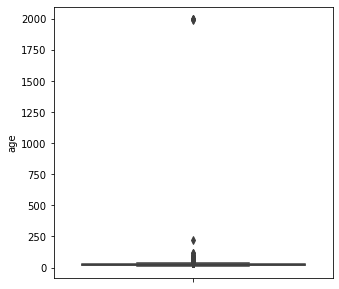

In [612]:
#handling outliers
plt.figure(figsize=(5,5))
sns.boxplot(y='age',data=df_select)

In [613]:
def outlier_Fun(x):
    mean = np.mean(x) 
    std = np.std(x) 
    print('Mean :', mean) 
    print('STD :', std)
    threshold = 3
    outlier = [] 
    for i in x: 
        z = (i-mean)/std 
        if z > threshold: 
            outlier.append(i) 
    return outlier

In [614]:

df_select = df_select[~df_select['age'].isin(outlier_Fun(df_select.age))]#function to remove outliers

Mean : 23.611796947678073
STD : 21.58178905719188


<AxesSubplot:ylabel='familysize'>

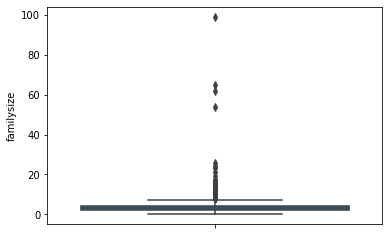

In [615]:
sns.boxplot(y='familysize',data=df_select)

In [616]:
df_select = df_select[~df_select['familysize'].isin(outlier_Fun(df_select.familysize))]#function to remove outliers

Mean : 3.5070666934916006
STD : 2.0408698488503023


In [617]:
df_select.shape

(39354, 18)

<h3>Feature Engineering</h3>

In [618]:
#updating category to 5
df_select.loc[~df_select['country'].isin(['MY','US']), ['country']] = 'other'

In [619]:
print(df_select['country'].unique())

['other' 'US' 'MY']


In [620]:
df_select['country'].value_counts()

MY       21265
other     9929
US        8160
Name: country, dtype: int64

In [621]:
df_select.loc[~df_select['religion'].isin([1,2,4,10]), ['religion']] = 0

In [622]:
df_select['religion'].value_counts()

10    21729
0      7477
2      3832
1      3242
4      3074
Name: religion, dtype: int64

In [623]:
df_select.loc[~df_select['familysize'].isin([1,2,3,4]), ['familysize']] = 0

In [624]:
df_select['familysize'].value_counts()

0    10653
3     9202
2     9015
4     7538
1     2946
Name: familysize, dtype: int64

In [625]:
df_select.loc[~df_select['race'].isin([10,60,70]), ['race']] = 0

In [626]:
df_select['race'].value_counts()

10    22773
60    10629
70     4788
0      1164
Name: race, dtype: int64

In [627]:
df_select.describe()

,education,urban,gender,age,religion,race,voted,married,familysize,Extraversion,Agreeableness,Conscientiousness,EmotionalStability,Openness,Anxiety_Lvl,Stress_Lvl,Depression_Lvl
count,39354.000000,39354.000000,39354.000000,39354.000000,39354.000000,39354.000000,39354.000000,39354.000000,39354.000000,39354.000000,39354.000000,39354.000000,39354.000000,39354.000000,39354.000000,39354.000000,39354.000000
mean,2.501448,2.224704,1.788967,23.374041,6.110993,30.508462,1.706942,1.158281,2.000661,2.965493,4.039513,3.728249,2.734716,4.102912,0.508995,0.360675,0.505107
std,0.885433,0.802822,0.444586,8.554103,4.426300,26.374027,0.472859,0.444548,1.468911,1.555981,1.229963,1.491942,1.527332,1.335788,0.499925,0.480202,0.499980
min,0.000000,0.000000,0.000000,13.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,2.000000,2.000000,18.000000,1.000000,10.000000,1.000000,1.000000,0.000000,1.500000,3.500000,2.500000,1.500000,3.500000,0.000000,0.000000,0.000000
50%,3.000000,2.000000,2.000000,21.000000,10.000000,10.000000,2.000000,1.000000,2.000000,3.000000,4.000000,3.500000,2.500000,4.000000,1.000000,0.000000,1.000000
75%,3.000000,3.000000,2.000000,25.000000,10.000000,60.000000,2.000000,1.000000,3.000000,4.000000,5.000000,5.000000,3.500000,5.000000,1.000000,1.000000,1.000000
max,4.000000,3.000000,3.000000,85.000000,10.000000,70.000000,2.000000,3.000000,4.000000,7.000000,7.000000,7.000000,7.000000,7.000000,1.000000,1.000000,1.000000


<h3>Data Visualization</h3>

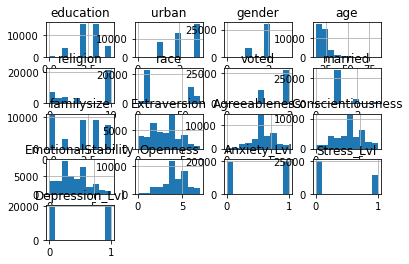

In [628]:
# histograms of the variables
df_select.hist()
plt.show()

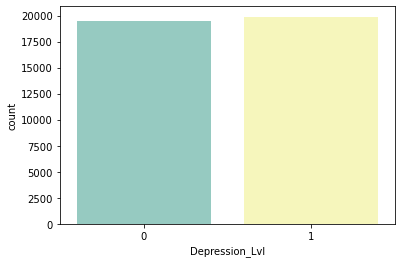

In [629]:
ax = sns.countplot(x="Depression_Lvl", data=df_select, palette="Set3")

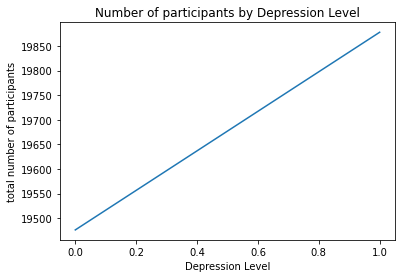

In [630]:
#number of participants by Depression Category
t= df_select.groupby(df_select.Depression_Lvl).Depression_Lvl.count().sort_index()#.plot(kind='bar')
plt.title('Number of participants by Depression Level')
plt.xlabel('Depression Level')
plt.ylabel('total number of participants');
plt.plot(t)
plt.show()

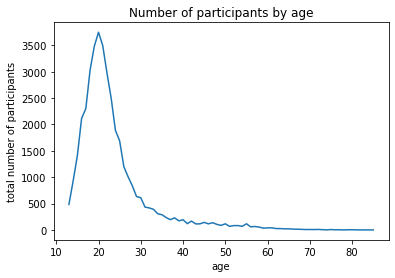

In [631]:
#number of participants by age 
t= df_select.groupby(df_select.age).age.count().sort_index()
plt.title('Number of participants by age')
plt.xlabel('age')
plt.ylabel('total number of participants');
plt.plot(t)
plt.show()

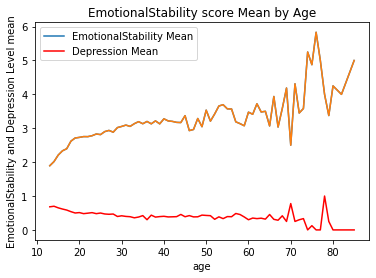

In [632]:
#EmotionalStability score Mean by Age
t= df_select.groupby(df_select.age).EmotionalStability.mean().sort_index()
t1= df_select.groupby(df_select.age).Depression_Lvl.mean().sort_index()
plt.title('EmotionalStability score Mean by Age')
plt.xlabel('age')
plt.ylabel('EmotionalStability and Depression Level mean');
plt.plot(t, label = 'EmotionalStability Mean') 
plt.plot(t1,color = 'red', label = 'Depression Mean')
plt.legend(loc = 'upper left')
plt.plot(t)
plt.show()

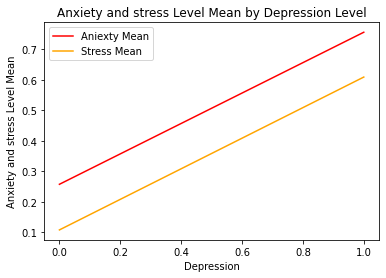

In [633]:
#Dep Lvl  by Aniexty
t= df_select.groupby(df_select.Depression_Lvl).Anxiety_Lvl.mean().sort_index()
t1= df_select.groupby(df_select.Depression_Lvl).Stress_Lvl.mean().sort_index()#.plot(kind='bar')
plt.title('Anxiety and stress Level Mean by Depression Level')
plt.xlabel('Depression')
plt.ylabel('Anxiety and stress Level Mean');
plt.plot(t,color = 'red', label = 'Aniexty Mean') 
plt.plot(t1,color = 'orange', label = 'Stress Mean')
plt.legend(loc = 'upper left')
plt.show()

<h3>Encoding </h3>

In [634]:
df2=df_select.drop(columns=[ 'urban','gender','religion','Stress_Lvl'])

In [635]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39354 entries, 0 to 39774
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   country             39354 non-null  object 
 1   education           39354 non-null  int64  
 2   age                 39354 non-null  int64  
 3   race                39354 non-null  int64  
 4   voted               39354 non-null  int64  
 5   married             39354 non-null  int64  
 6   familysize          39354 non-null  int64  
 7   Extraversion        39354 non-null  float64
 8   Agreeableness       39354 non-null  float64
 9   Conscientiousness   39354 non-null  float64
 10  EmotionalStability  39354 non-null  float64
 11  Openness            39354 non-null  float64
 12  Anxiety_Lvl         39354 non-null  int64  
 13  Depression_Lvl      39354 non-null  int64  
dtypes: float64(5), int64(8), object(1)
memory usage: 5.5+ MB


In [637]:
#encode X except age
Cateforical = ['country','education','voted', 'married','Anxiety_Lvl']
enc = OrdinalEncoder()
df2[Cateforical] =enc.fit_transform(df2[Cateforical])

In [638]:
df2.iloc[:,13]

0        1
1        1
2        1
3        0
4        1
        ..
39770    1
39771    1
39772    0
39773    0
39774    1
Name: Depression_Lvl, Length: 39354, dtype: int64

In [640]:
#y encoding
label_encoder = LabelEncoder()
df2.iloc[:,13] = label_encoder.fit_transform(df2.iloc[:,13]).astype('float64')

Class=1, n=19878 (50.511%)
Class=0, n=19476 (49.489%)


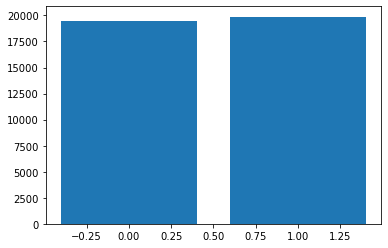

In [641]:
# summarize distribution to see if there is imbalance
import imblearn
from collections import Counter
counter = Counter(df2.iloc[:,13])
for k,v in counter.items():
    per = v / len(df2.iloc[:,13]) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

In [642]:
#the distribution looks normal

<h3>Feature Scaling</h3>

In [643]:
# retrieve numpy array
dataset = df2.values

X = dataset[:, :-1]
y = dataset[:,-1]
# format all fields as string
X = X.astype(float)


In [644]:
from sklearn.preprocessing import MinMaxScaler
# define min max scaler
scaler = MinMaxScaler()
# transform data
X = scaler.fit_transform(X)

In [645]:
X,y

(array([[1.        , 0.5       , 0.04166667, ..., 0.07142857, 0.92857143,
         1.        ],
        [0.5       , 0.5       , 0.04166667, ..., 0.07142857, 0.5       ,
         1.        ],
        [1.        , 0.5       , 0.05555556, ..., 0.57142857, 0.71428571,
         0.        ],
        ...,
        [0.5       , 0.75      , 0.48611111, ..., 0.5       , 0.64285714,
         0.        ],
        [0.5       , 0.75      , 0.09722222, ..., 0.21428571, 0.42857143,
         0.        ],
        [0.        , 0.75      , 0.18055556, ..., 0.21428571, 0.78571429,
         0.        ]]),
 array([1., 1., 1., ..., 0., 0., 1.]))

<h3>Modeling</h3>

In [655]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

trying different model and camparing the result

In [656]:
def printScore(modelname, TrainScore,TestScore):
    print('--'+modelname+'---')
    print('Train Precdict Score| Test Predict Score')
    print('----------------------------------------')
    print(' ',TrainScore,'                  ',TestScore)

In [677]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics #Evalution metrices 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

<h4>1-KNN</h4>

In [658]:
knn = KNeighborsClassifier(n_neighbors = 5 )
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
kns =accuracy_score(y_test, y_pred) * 100
kns

72.38079105615313

In [680]:
knn = KNeighborsClassifier(n_neighbors = 10 )
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
kns =accuracy_score(y_test, y_pred) * 100
kns

73.490302363005

In [683]:
scores = cross_val_score(knn, X, y, cv=5)
scores

array([0.72786177, 0.72849701, 0.74755431, 0.74450515, 0.72465057])

In [684]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.73 accuracy with a standard deviation of 0.01


increasing the number of neighbors improve performance slightly

<h4>2-LogisticRegression</h4>

In [660]:
#normal>> no feature selection
# fit the model
lr = LogisticRegression(solver='lbfgs',max_iter=2000,random_state=0)
lr.fit(X_train, y_train)
# evaluate the model
yhat = lr.predict(X_test)
# evaluate predictions
accuracy = accuracy_score(y_test, yhat)
print('Accuracy: %.2f' % (accuracy*100))

Accuracy: 75.97


In [689]:
scores = cross_val_score(lr, X, y, cv=5)
scores

array([0.75200102, 0.74628383, 0.77537797, 0.77143946, 0.75679797])

In [690]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.76 accuracy with a standard deviation of 0.01


<h4>3-SVM</h4>

In [664]:

SVM = svm.SVC(kernel='linear', decision_function_shape="ovo").fit(X_train, y_train)
ypred= SVM.predict(X_test)
SvmTs=round(SVM.score(X_test, y_test), 4)

In [665]:
SvmT=round(SVM.score(X_train, y_train), 4)

In [666]:
printScore('Support Vector Machine with linear kernel',SvmT,SvmTs)

--Support Vector Machine with linear kernel---
Train Precdict Score| Test Predict Score
----------------------------------------
  0.748                    0.7529


In [693]:
#changing kernel to rbf
SVM = svm.SVC(kernel='rbf',C=1, decision_function_shape="ovo").fit(X_train, y_train)
ypred= SVM.predict(X_test)
SvmTs=round(SVM.score(X_test, y_test)*100, 4)

In [694]:
SvmT=round(SVM.score(X_train, y_train)*100, 4)

In [695]:
printScore('Support Vector Machine with rbf kernel',SvmT,SvmTs)

--Support Vector Machine with rbf kernel---
Train Precdict Score| Test Predict Score
----------------------------------------
  75.8776                    76.0481


In [691]:
scores = cross_val_score(SVM, X, y, cv=5)
scores

array([0.74717317, 0.74475924, 0.77169356, 0.77080422, 0.75590851])

In [692]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.76 accuracy with a standard deviation of 0.01


SVN with rbf give better result compare to linear

In [696]:
#changing decision_function_shape
SVM = svm.SVC(kernel='linear', decision_function_shape="ovr").fit(X_train, y_train)
ypred= SVM.predict(X_test)
SvmTs=round(SVM.score(X_test, y_test), 4)

In [697]:
SvmT=round(SVM.score(X_train, y_train), 4)

In [698]:
printScore('Support Vector Machine with ovr decision_function_shape',SvmT,SvmTs)

--Support Vector Machine with ovr decision_function_shape---
Train Precdict Score| Test Predict Score
----------------------------------------
  0.748                    0.7529


In [543]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.77      0.80      0.78      4907
         1.0       0.79      0.76      0.78      4932

    accuracy                           0.78      9839
   macro avg       0.78      0.78      0.78      9839
weighted avg       0.78      0.78      0.78      9839



<h4>4-RandomForestClassifier</h4>

In [699]:
RF = RandomForestClassifier(n_estimators=1000, max_depth=5, random_state=0).fit(X_train, y_train)
y_pred= RF.predict(X_test)
RF_Ts = round(RF.score(X_test, y_test), 4)

In [700]:
RF_Tr=round(RF.score(X_train, y_train),4)

In [701]:
print('Train Precdict Score| Test Predict Score')
print('----------------------------------------')
print(' ',RF_Tr,'                  ',RF_Ts)

Train Precdict Score| Test Predict Score
----------------------------------------
  0.7633                    0.7618


In [704]:
cm=confusion_matrix(y_test,y_pred)
cmdf=pd.DataFrame(cm)
cmdf

,0,1
0,4286,1551
1,1261,4709


In [705]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.77      0.73      0.75      5837
         1.0       0.75      0.79      0.77      5970

    accuracy                           0.76     11807
   macro avg       0.76      0.76      0.76     11807
weighted avg       0.76      0.76      0.76     11807



In [706]:
scores = cross_val_score(RF, X, y, cv=5)
scores

array([0.74793546, 0.7488248 , 0.77474273, 0.772837  , 0.75972046])

In [707]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.76 accuracy with a standard deviation of 0.01
